# Coherent noise studies

In [1]:
# %reset -f
import numpy as np
from LebedevHelper import *

import matplotlib.pyplot as plt
import scipy
import scipy.stats as st
import scipy.special as spec
import matplotlib as mpl
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import scipy.integrate as integrate

import pickle as pkl

%matplotlib notebook


In [2]:
ticksize= 12
titlesize = 18
mpl.rcParams.update({'font.size':ticksize }) # legend
mpl.rcParams.update({'ytick.labelsize':ticksize })
mpl.rcParams.update({'xtick.labelsize':ticksize})
mpl.rcParams.update({'axes.labelsize':titlesize})    # x,y,cbar labels
mpl.rcParams.update({'figure.titlesize':titlesize})
mpl.rcParams.update({'axes.titlesize':titlesize})       # Title
mpl.rcParams.update({'savefig.bbox':'tight'})
mpl.rcParams.update({'axes.formatter.limits':[-4,4]})
mpl.rcParams.update({'figure.figsize':[6,5]})
mpl.rcParams.update({'mathtext.fontset':'cm'})
mpl.rcParams.update({'font.style':'normal'})
mpl.rcParams.update({'image.cmap':'rainbow'})

In [6]:
def rotation(a,b,C,S):
    temp = a
    a = C*a  + S*b
    b = -S*temp + C*b
    return a,b

def filament(a,b,dep,lim):
    ind = dep>lim
    N = np.size(a)
    phi = np.random.uniform(0,2*np.pi,np.sum(ind))
    A = np.sqrt(a**2+b**2)
    a[ind] = A[ind]*np.cos(phi)
    b[ind] = A[ind]*np.sin(phi)
    return a,b
    
def filament_lin(a,b,dep,fac=1):
    phi = np.random.uniform(0,2*np.pi,np.size(a))*dep/fac
#     A = np.sqrt(a**2+b**2)
#     a = A*np.cos(phi)
#     b = A*np.sin(phi)
    return rotation(a,b,np.cos(phi),np.sin(phi))
    
    
def kick(a,kick):
    a += kick
    return a

def noise(NN,DD):
    return np.random.randn(NN)*DD

def noise_coh(DD):
#     return np.random.uniform(-1,1)*DD
    return np.random.randn(1)*DD

def damper(a,b,g,w):
    b -= g*np.average(b,weights=w)
    return a,b

def damper_ideal(a,b,g,w):
    a -= g/2*np.average(a,weights=w)
    b -= g/2*np.average(b,weights=w)
    return a,b


def act(a,b,w):
    return 0.5*((a-np.average(a,weights=w))**2+(b-np.average(b,weights=w))**2)

def act_abs(a,b):
    return 0.5*((a)**2+(b)**2)



#############################################
########### Number analysis #################
def edges_to_center(edges):
    return (edges[1:]+edges[:-1])*.5


####################################################
########### Analytical predictions #################
def anal_dJxdJz(J,g2,Qp,sigdpp= 1.129E-4):
    return (1-g2)*(1-1/np.sqrt(1+2*pi2**2*(1-g2)/g2**2*Qp**2*sigdpp**2*J))

def func_g2(g):
    return g/2
#     return 1-np.sqrt(1-g+g**2*0.5)

def lebfac(g,dq):
    g2 = func_g2(g)
    return pi2**2*(1-g2)**2*(dq)**2 / (pi2**2*(1-g2)*(dq)**2  + g2**2)

def integrand_octupole(Jy,Jx,a,b,g,mJx=1,mJy=1):
    dq = a*(Jx-mJx)+b*(Jy-mJx)
    return lebfac(g,dq)*np.exp(-Jy)

def anal_dJxdJx_octu(Jx,a,b,g,mJx=1,mJy=1):
    leb = np.zeros_like(Jx)
    for i,J in enumerate(Jx):
        leb[i] = integrate.quad(integrand_octupole,0,100,args = (J,a,b,g,mJx,mJy))[0]
    return leb


#####################################################################
def sci_not(num,dec):
    exp = int(np.log10(num)+100)-100
    sci = (r"$%.10f"%(num/10**exp))[:dec+2+1*(dec>0)]+r"\cdot10^{%d}$"%exp
    return sci


In [7]:
N = int(1e6)
Qs = 0 # 0.002
Qx = 0.31
Qy = 0.32
dpp = 1.129e-4
SX = np.sin(Qx*2*np.pi)
CX = np.cos(Qx*2*np.pi)
SY= np.sin(Qy*2*np.pi)
CY= np.cos(Qy*2*np.pi)
SS= np.sin(Qs*2*np.pi)
CS= np.cos(Qs*2*np.pi)
pi2 = 2*np.pi

bool_J0 = 1

turns =100
D = 1e-4 *10
sep = 0.1  *0
# D = sep*np.sqrt(3/turns)  ; sep=0
maxj=4
# sep = np.sqrt(1/30)

gfac = 1
fac  = 1
g= 0.02  * gfac
Qp = 0
a = 1e-4 * fac*gfac
b = 0
# a=0

tau1 = 2/g if g>0 else np.inf
tau2 = 0.135/np.sqrt(a**2+b**2)
tau = (tau1*tau2)/(tau1+tau2)
print('tau',tau,tau1,tau2)

L = D
anal_equi = L/np.sqrt(3)*np.sqrt(tau*0.5)
print('Analytical equilibrium= %.3f'%anal_equi)

bparam = np.zeros((4,turns))
if 1:
    x = np.random.randn(N)
    p = np.random.randn(N)
    s = np.random.randn(N)
    d = np.random.randn(N)
    w = np.ones(N)
else:
    
    jx0 = np.random.uniform(0,maxj,N)
    phix0=np.random.uniform(0,pi2,N)
    x = np.sqrt(2*jx0)*np.cos(phix0)
    p = np.sqrt(2*jx0)*np.sin(phix0)
    js0 = np.random.uniform(0,maxj,N)  *0
    phis0=np.random.uniform(0,pi2,N)
    s = np.sqrt(2*js0)*np.cos(phis0)
    d = np.sqrt(2*js0)*np.sin(phis0)
    w = np.exp(-jx0-js0)
    w = w*N/np.sum(w)
    
x0 = np.copy(x)
p0 = np.copy(p)
s0 = np.copy(s)
d0 = np.copy(d)

jx0 = act(x,p,w)   ;    jz0 = act(s,d,w)
jxa0 = act_abs(x,p);   jza0 = act_abs(s,d)


Qfil = Qp*dpp*d
CQfil = np.cos(2*np.pi*Qfil)
SQfil = np.sin(2*np.pi*Qfil)
Qoct = a*jxa0 + b *jza0
CQoct0 = np.cos(2*np.pi*Qoct)
SQoct0 = np.sin(2*np.pi*Qoct)

avgs1 = []
xs1 = []
turns1 = []

avgs2 = []
xs2 = []
turns2 = []

##################################
####### Define single turns ######
#         s,d = rotation(s,d,CS,SS)
#         x,p = filament(x,p,x**2 + p**2,0)
#         x,p = filament_lin(x,p,d,100)
#         x,p = filament_lin(x,p,np.sqrt(x**2 + p**2),100)
#         x,p = rotation(x,p,CQfil,SQfil)

def OTM_qp(x,p,s,d ,w):
    x,p = rotation(x,p,CX,SX)
    x,p = rotation(x,p,CQfil,SQfil)
    s,d = rotation(s,d,CS,SS)
    x,p = damper(x,p,g,w)
    return x,p,s,d 

def OTM_oct_simple(x,p,s,d,w ):
    x,p = rotation(x,p,CX,SX)
    x,p = rotation(x,p,CQoct0,SQoct0)
    x,p = damper_ideal(x,p,g,w)
    return x,p,s,d 

def OTM_oct(x,p,s,d ,w):
    if not bool_J0:
        jxa = act_abs(x,p)
        jza = act_abs(s,d)
        Qoct = a*jxa + b *jza
        CQoct = np.cos(2*np.pi*Qoct)
        SQoct = np.sin(2*np.pi*Qoct)
    else:
        CQoct = CQoct0
        SQoct = SQoct0

    s,d = rotation(s,d,CY,SY)
    x,p = rotation(x,p,CX,SX)
    x,p = rotation(x,p,CQoct,SQoct)
#     x,p = damper(x,p,g,w)
    x,p = damper_ideal(x,p,g,w)
    return x,p,s,d 

def OTM_oct_1D(x,p ,w):
    if not bool_J0:
        jxa = act_abs(x,p)
        Qoct = a*jxa 
        CQoct = np.cos(2*np.pi*Qoct)
        SQoct = np.sin(2*np.pi*Qoct)
    else:
        CQoct = CQoct0
        SQoct = SQoct0

    x,p = rotation(x,p,CX,SX)
    x,p = rotation(x,p,CQoct,SQoct)
#     x,p = damper(x,p,g,w)
    x,p = damper_ideal(x,p,g,w)
    return x,p


################################
########## Simulate ############
method =3
noisecount = 0
if method ==1 :
    for turn in range(turns):
        x,p = rotation(x,p,CX,SX)
        p += noise_coh(D)
        
elif method ==2:
    plt.figure()
    plt.hist2d(x,p,bins = 100)
    plt.grid(True)
    print(np.std(x)**2+np.std(p)**2)
    
    p = kick(p,1)
    plt.figure()
    plt.hist2d(x,p,bins = 100)
    plt.grid(True)
    print(np.std(x)**2+np.std(p)**2)
    
#     x,p = filament_lin(x,p,x**2 + p**2,1)
    x,p = filament_lin(x,p,d,2)
#     x,p = filament(x,p,x**2 + p**2,0)
    plt.figure()
    plt.hist2d(x,p,bins = 100)
    plt.grid(True)
    print(np.std(x)**2+np.std(p)**2)
    
elif method == 3:

    jx0s = act(x,p,w)    ;    jz0 = act(s,d,w)
    p = kick(p,sep)

    for turn in range(turns):
        p += noise_coh(D)  ; noisecount+=1
#         p += D/np.sqrt(3)
        
#         x,p,s,d = OTM_oct_simple(x,p,s,d,w)
#         x,p,s,d = OTM_oct(x,p,s,d,w)
        x,p = OTM_oct_1D(x,p,w)

#         x,p,s,d = OTM_qp(x,p,s,d,w)
        
        bparam[:,turn] = np.average([x,p,x**2,p**2],axis=1,weights=w)
        
        if turn%100==0:
            print('turn ', turn)

elif method == 4:
    p += sep
    p += sep



jx  = act(x,p,w)  ;   jz = act(s,d,w)
jxa = act_abs(x,p);   jza = act_abs(s,d)


print('Relative actions \n Before: Jx = %.3f | Jz = %.3f \n After:  Jx = %.3f | Jz = %.3f'%(
        np.average(jx0,weights=w),np.average(jz0,weights=w),np.average(jx,weights=w),np.average(jz,weights=w)))
print('Absolute actions \n Before: Jx = %.3f | Jz = %.3f \n After:  Jx = %.3f | Jz = %.3f'%(
        np.average(jxa0,weights=w),np.average(jza0,weights=w),np.average(jxa,weights=w),np.average(jza,weights=w)))



tau 93.1034482759 100.0 1350.0
Analytical equilibrium= 0.004
turn  0
Relative actions 
 Before: Jx = 0.999 | Jz = 0.999 
 After:  Jx = 0.999 | Jz = 0.999
Absolute actions 
 Before: Jx = 0.999 | Jz = 0.999 
 After:  Jx = 0.999 | Jz = 0.999


In [9]:
if 1:
    turn2 =300
    temp = bparam
    turnold = temp.shape[1]
    bparam = np.zeros((temp.shape[0],turnold+turn2))
    bparam[:,:turnold] = temp
    
    for turn in range(turnold,turnold+turn2):
#         p += noise_coh(D)  ; noisecount+=1
#         x,p,s,d = OTM_oct_simple(x,p,s,d,w)
#         x,p,s,d = OTM_oct(x,p,s,d,w)
        x,p = OTM_oct_1D(x,p,w)
#         x,p,s,d = OTM_qp(x,p,s,d,w)

        bparam[:,turn] = np.average([x,p,x**2,p**2],axis=1,weights=w)
        if turn%100==0:
            print('turn ', turn)

    jx = act(x,p,w)   ;    jz = act(s,d,w)
    jxa = act_abs(x,p);   jza = act_abs(s,d)

bparam.shape
# bparam[2]

turn  100
turn  200
turn  300


(4, 400)

average growth: -2.287e-06


<IPython.core.display.Javascript object>


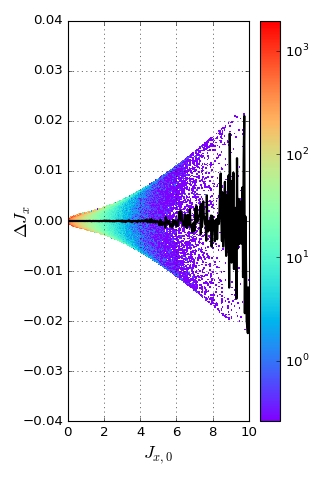

<IPython.core.display.Javascript object>


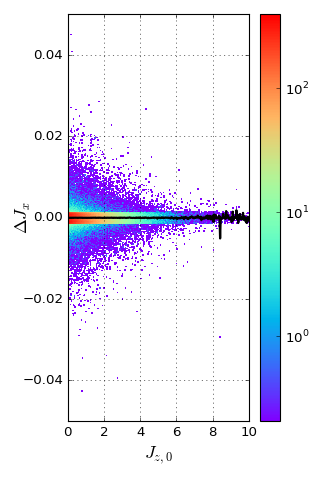

<IPython.core.display.Javascript object>


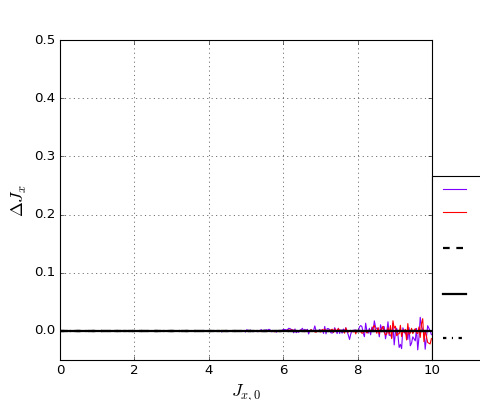

Turns=100, minimum at J_x 2.05
Turns=400, minimum at J_x 2.95
Noise induced growth 8.33333333333e-06 [100, 400]
1.6666666666666664e-05


<IPython.core.display.Javascript object>


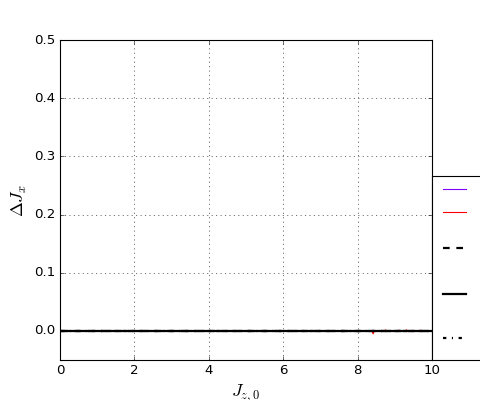

Turns=100, minimum at J_z 2.88
Turns=400, minimum at J_z 2.88
Noise induced growth 8.33333333333e-06 [100, 400]


<IPython.core.display.Javascript object>


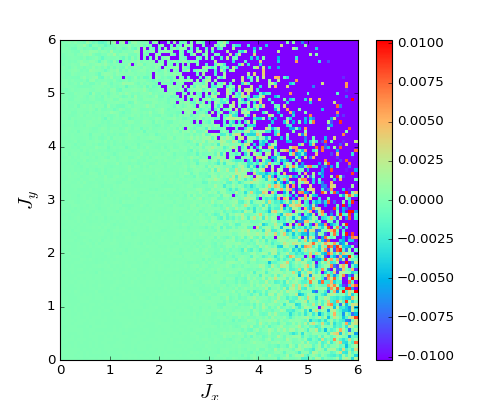

/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:173: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>


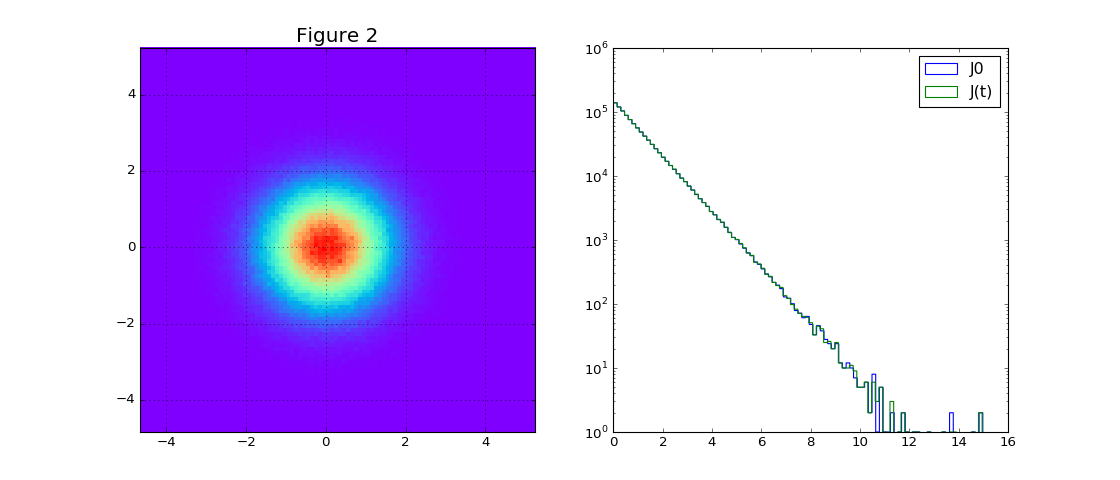

Line 15x


<IPython.core.display.Javascript object>


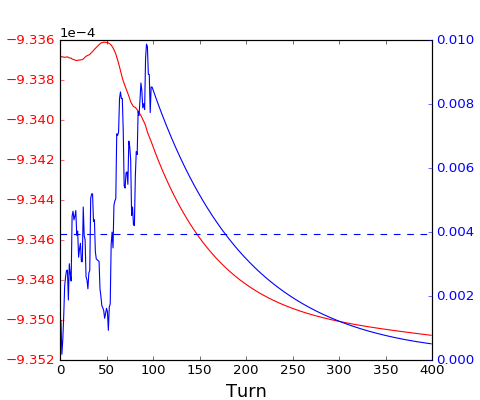

Analytical equilibrium  0.00393919298579
Numerical equilibrium   0.00401017077823


<IPython.core.display.Javascript object>


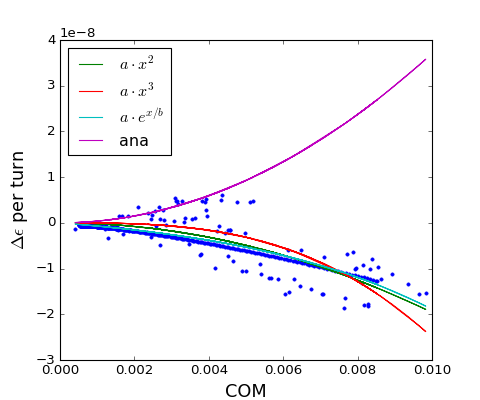

rms error, x^2 2.43313970693e-09  | fit [-0.00019587]
rms error, x^3 2.83314485267e-09  | fit [-0.0250278]
rms error, e^x 2.4253846815e-09  | fit [ -3.39573796e-09   5.31283826e-03]
rms error, ana 1.49944389724e-08


<IPython.core.display.Javascript object>


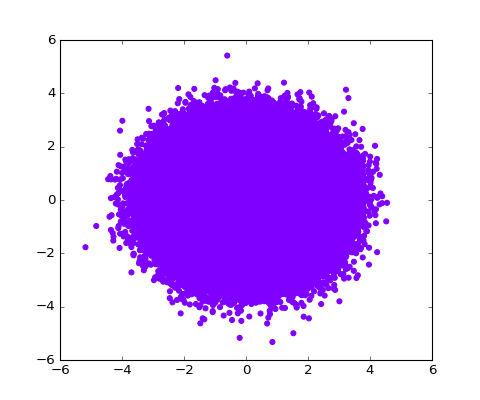

In [10]:
mJx = 1
mJy = 1
lim = 0.6*sep**2
lim=.5
xlim = 10

b= 0


# plt.figure(figsize=(10,6))
nbin = 300
XS = [jx0,jz0]
YS = [jx-jx0,jx-jx0]

XS = [jxa0,jz0]
YS = [jxa-jxa0,jx-jx0]


print('average growth: %.3e'%np.mean(YS[0]))



plot_deltaAct = 1
plot_deltaDist= 1
#for i in [1]:
if plot_deltaAct:       
    for j in range(2):
        fig=plt.figure(figsize=(4,6))
        ax1 = plt.subplot(111)
    #     H,xedges,yedges = np.histogram2d(XS[j],YS[j],nbin,range=[[0,np.max(XS[j])],[0,np.max(YS[j])]],normed=True);
        xlims = [0,10] #[np.min(XS[j]),np.max(XS[j])]
        H,xedges,yedges = np.histogram2d(XS[j],YS[j],[nbin,nbin*2],range=[xlims,
                                                                 [np.min(YS[j]),np.max(YS[j])]],weights=w ,normed=True);

        H = H.transpose()

        vmax = H.max()
        vmin = np.min(H[H>0])

    #     vmin= 3e-2 ; vmax=5e2

        X,Y = np.meshgrid(xedges, yedges);
        X2,Y2=np.meshgrid(edges_to_center(xedges),edges_to_center(yedges))
        pcm=plt.pcolor(X,Y,H,norm =LogNorm(vmin=vmin,vmax=vmax),cmap='rainbow');
#         pcm=plt.contourf(X2,Y2,H,levels=np.logspace(np.log10(vmin),np.log10(vmax),100),norm =LogNorm(vmin=vmin,vmax=vmax),cmap='rainbow');
        plt.colorbar(pcm, ax=ax1 ,ticks=np.logspace(-4,4,9))#, extend='max')
        plt.xlabel([r'$J_{x,0}$',r'$J_{z,0}$'][j],fontsize=16)
        plt.ylabel(r'$\Delta J_x$',fontsize=16)

        ind = np.sum(H,axis=0)>0
        avg = np.average(Y[1:,1:][:,ind],weights=H[:,ind],axis =0)-np.diff(yedges)[0]*0.5

        plt.plot(xedges[1:][ind]-np.diff(xedges)[0]*0.5,avg,'k',lw=2)
        plt.grid(True)


        # Save data
        endturn = np.shape(bparam)[1]
        if j ==0:
            if not (endturn in turns1):
                avgs1 += [avg]
                xs1   += [xedges[1:][ind]-np.diff(xedges)[0]*0.5]
                turns1+= [endturn]
        elif j == 1:
            if not (endturn in turns2):
                avgs2 += [avg]
                xs2   += [xedges[1:][ind]-np.diff(xedges)[0]*0.5]
                turns2+= [endturn]


        if j==0:
    #         plt.ylim(-0.002,0.4*.5*sep**2)
    #         plt.ylim(-0.002,0.6*.5*D**2*turns)
    #         plt.ylim(-0.1,0.6)
            plt.xlim(0,10)
#             plt.axis([0,6,-.11,.11])

        ax1.yaxis.labelpad=-10
        plt.tight_layout()

    #     fig.subplots_adjust(left=0.2, wspace=0.6)
    
    ###############################################
    ##### Plot of emittance growth since start ####

    for j in range(2):
        plt.figure()
        for i in range(len(turns1)):
            c=cm.rainbow(i/max(1,len(turns1)-1))
            if j ==0:
                plt.plot(xs1[i],avgs1[i],c=c,label='Turn=%d'%(turns1[i]))
                print('Turns=%d, minimum at J_x %.2f'%(turns1[i],xs1[i][np.argmin(avgs1[i][xs1[i]<3])]))

            elif j==1:
                plt.plot(xs2[i],avgs2[i],c=c,label='Turn=%d'%(turns2[i]))
                print('Turns=%d, minimum at J_z %.2f'%(turns2[i],xs2[i][np.argmin(avgs2[i][xs2[i]<3])]))
        plt.xlabel([r'$J_{x,0}$',r'$J_{z,0}$'][j],fontsize=16)
        plt.ylabel(r'$\Delta J_x$',fontsize=16)


        # Analytical solutions (Lebedev)
        sepanal = 0.5*sep**2
        TT=turns1[-1]
        TT= turns
        TT = noisecount
        noiseanal=0.5*anal_equi**2  * TT   /tau
        noiseAsSep = 0.5*L**2/3 * TT # = 0.5 sep^2 -> L = sep*np.sqrt(3/TT)
        if (a>0 or b>0) and Qp ==0 :
            if sep >0:
                print('Separation induced growth',sepanal)
                g0growth = sepanal
                f = anal_dJxdJx_octu(xs1[i],a,b,g,mJx,mJy)
    #             f = sepanal* ( anal_dJxdJx_octu(xs1[i],a,b,g,mJx,mJy)
    #                           +anal_dJxdJx_octu(xs1[i],a,b,g,mJx*0.5,mJy*0.5)
    #                           +anal_dJxdJx_octu(xs1[i],a,b,g,mJx*0,mJy*0)) / 3
                plt.plot(xs1[i],sepanal*f,
                         'k--',lw=2,label='Analytical \n'+ r'$a=%.0e , b=%.0e$'%(a,b))        
            elif D >0:
                noiseanal=0.5*anal_equi**2  * TT   /tau
                fac=0.7
                plt.plot(xs1[i],noiseanal*anal_dJxdJx_octu(xs1[i],a*fac,b*fac,g,mJx,mJy),
                         'k--',lw=2,label=r'Analytical, %d turns, $\tau_{Tot}$'%TT+ '\n'+ r'$a=%.0e , b=%.0e$'%(a*fac,b*fac))        
                print('Noise induced growth',noiseanal,turns1)
                noiseanal=0.5*anal_equi**2  * TT   /tau2
                fac=1
                g0growth = noiseAsSep
                f = anal_dJxdJx_octu( xs1[i],a*fac*(1-j)+j*b*fac,b*fac*(1-j)+j*a*fac,g,mJx,mJy)
                plt.plot(xs1[i],noiseanal*f,
                         'k',lw=2,label=r'Analytical, %d turns, $\tau_{Dec}$'%TT+ '\n'+ r'$a=%.0e , b=%.0e$'%(a*fac,b*fac))        
                plt.plot(xs1[i],noiseAsSep*f,
                         'k-.',lw=2,label=r'Analytical, %d turns, Separation'%TT+ '\n'+ r'$a=%.0e , b=%.0e$'%(a*fac,b*fac))        
            if j==0:
                fn = 'djxdjx0_%d_%.0e_%.0e_%.0e_%.0e'%(bool_J0,sep,N,g,a)
                fn = 'djxdjx0_%.0e_%.0e_%.0e_%.0e_%d_%.0e'%(sep,D,g,a,bool_J0,N)
                with open(fn,'wb') as file:
                    pkl.dump([xs1[i],avgs1[i],g0growth*f,[a,b,g,sep,D,TT]],file)
                print(g0growth)

        elif j == 1 and Qp>0:
            # Analytical for chromaticity
            g2 = g/2

            Qpr = 0.8*Qp
            plt.plot(xs2[i],sepanal*anal_dJxdJz(xs2[i],g2,Qpr,sigdpp= 1.129E-4),
                     'k--',lw=2,label=r'Analytical $(Q^\prime=%.1f)$'%Qpr)
            plt.plot(xs2[i],sepanal*anal_dJxdJz(xs2[i],g2,Qp,sigdpp= 1.129E-4),
                     'k',lw=2,label=r'Analytical $(Q^\prime=%.1f)$'%Qp)

        plt.grid(True)
        plt.ylim(-min(0.1*lim,0.1),lim)     ;   plt.xlim(0,xlim)

        plt.legend(loc = (1,0))

        
    # plt.figure()
    # for i in range(len(turns1)):
    #     plt.plot(xs2[i],avgs2[i],label=str(turns2[i]))
    # plt.grid(True)
    # plt.ylim(-lim,lim)    ; plt.xlim(0,xlim)
    # plt.legend(loc = (1,0))

#     break

    #### Change of distribution
    plt.figure()
    nbin2=100
    Jmax=6
    DJx = jx-jx0
    # H3,xedges,yedges = np.histogram2d(Jx0,Jy0,nbin2,range=[[0,Jmax],[0,Jmax]],weights=DJx);
    W,xedges,yedges = np.histogram2d(jx0,jz0,nbin2,range=[[0,Jmax],[0,Jmax]],weights=w); #weights=1
    H3,xedges,yedges = np.histogram2d(jx0,jz0,nbin2,range=[[0,Jmax],[0,Jmax]],weights=DJx);
    X,Y = np.meshgrid(xedges,yedges)
    F=(H3/W).transpose()
    vmax =np.nanmax(np.abs(F))
    vmin=np.nanmin(F)
    plt.pcolor(X,Y,F,vmin=vmin,vmax=vmax)
    plt.colorbar()
    plt.xlabel(r'$J_x$')
    plt.ylabel(r'$J_y$')
    
if plot_deltaDist:
    ###################################################
    fig=plt.figure(figsize=(14,6))
    ax1 = fig.add_subplot(121)
    ax1.hist2d(x,p,bins = 100,weights=w)
    ax1.grid(True)
    ax1.set_title("Figure 2")

    ax2 = fig.add_subplot(122)
    if 0:
        ax2.hist(x,bins=100,histtype='step',label='x',weights=w)
        ax2.hist(p,bins=100,histtype='step',label='p',weights=w)
    else:
        ax2.hist(jxa0,bins=100,histtype='step',label='J0',weights=w)
        ax2.hist(jxa,bins=100,histtype='step',label='J(t)',weights=w)
        ax2.set_yscale('log')
    ax2.legend(loc=0)

    ####
    # plt.figure()
    if False:
        plt.figure()
        for j in range(4):
            plt.subplot(221+j)
            plt.plot(bparam[j,:10])

    ############################################
    ############################################
    print('Line 15x')
    plt.figure()
    ax1 = plt.subplot(111)
    ax1.set_xlabel('Turn',fontsize=16)
    ax1.set_ylabel('Emittance-1',fontsize=16)
    ind = bparam[2,:]>0
    emitt = 0.5*(bparam[2,ind]-bparam[0,ind]**2+bparam[3,ind]-bparam[1,ind]**2)
    ax1.plot(emitt-1,'r',label='Emittance')
    ax1.tick_params('y', colors='r')

    ax2 = ax1.twinx()
    ax2.set_ylabel('COM',fontsize=16)
    COM = np.sqrt(bparam[0,ind]**2+bparam[1,ind]**2)
    ax2.plot(COM,'b',label='COM')
    ax2.plot(np.ones(turns2[-1])*anal_equi,'b--')
    ax2.tick_params('y', colors='b')
    print('Analytical equilibrium ',anal_equi)
    print('Numerical equilibrium  ',np.sqrt(np.mean(COM**2)))

    def fit_2(x,a):
        return a*x**2
    def fit_3(x,a):
        return a*x**3
    def fit_e(x,a,b):
        return a*(np.exp(x/b)-1 )

    emit_growth = np.diff(emitt)
    COM_mean = 0.5*(COM[1:]+COM[:-1])
    # COM_mean = COM[:-1]
    plt.figure()
    plt.plot(COM_mean ,emit_growth,'.')
    fit2,cov2 = scipy.optimize.curve_fit(fit_2,COM_mean, emit_growth)
    plt.plot(COM_mean,fit_2(COM_mean,fit2),label=r'$a\cdot x^2$')
    err2 = np.sqrt(np.mean((emit_growth-fit_2(COM_mean,fit2))**2))

    fit3,cov3 = scipy.optimize.curve_fit(fit_3,COM_mean, emit_growth)
    err3 = np.sqrt(np.mean((emit_growth-fit_3(COM_mean,fit3))**2))
    plt.plot(COM_mean,fit_3(COM_mean,fit3),label=r'$a\cdot x^3$')

    fite,cove = scipy.optimize.curve_fit(fit_e,COM_mean, emit_growth)
    erre = np.sqrt(np.mean((emit_growth-fit_e(COM_mean,fite[0],fite[1]))**2))
    plt.plot(COM_mean,fit_e(COM_mean,fite[0],fite[1]),label=r'$a\cdot e^{x/b}$')

    ana_emit_growth = 0.5*COM_mean**2 /tau2 
    plt.plot(COM_mean,ana_emit_growth,label='ana')
    erra = np.sqrt(np.mean((emit_growth-ana_emit_growth)**2))

    plt.ylabel(r'$\Delta \epsilon $ per turn',fontsize=16)
    plt.xlabel('COM',fontsize=16)
    plt.legend(loc=0)


    print('rms error, x^2',err2,' | fit',fit2)
    print('rms error, x^3',err3,' | fit',fit3)
    print('rms error, e^x',erre,' | fit',fite)
    print('rms error, ana',erra)




    ### Action growth per x,p
    plt.figure()
    vmax = 0.5*sep**2 * 0.3
    plt.scatter(x0,p0,c=jx-jx0,edgecolors='Face',vmin=-vmax,vmax=vmax)

<IPython.core.display.Javascript object>


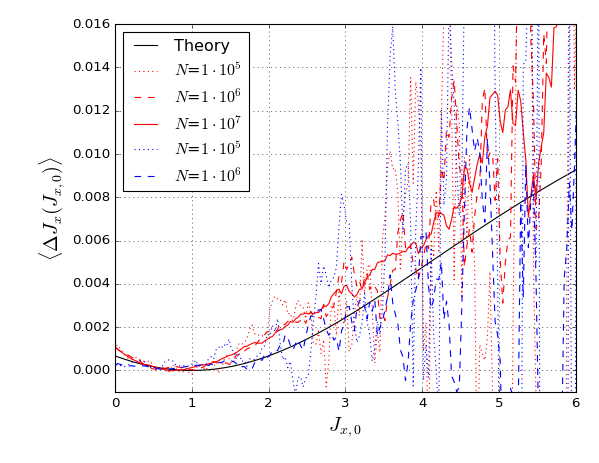

djxdjx0_2e-01_0e+00_2e-02_3e-04_0_1e+05
g 0.02 0.02
[0.00030000000000000003, 0, 0.02, 0.2, 0.0, 600]
djxdjx0_2e-01_0e+00_2e-02_3e-04_0_1e+06
[0.00030000000000000003, 0, 0.02, 0.2, 0.0, 600]
djxdjx0_2e-01_0e+00_2e-02_3e-04_0_1e+07
[0.00030000000000000003, 0, 0.02, 0.2, 0.0, 600]
djxdjx0_2e-01_0e+00_2e-02_3e-04_1_1e+05
[0.00030000000000000003, 0, 0.02, 0.2, 0.0, 600]
djxdjx0_2e-01_0e+00_2e-02_3e-04_1_1e+06
[0.00030000000000000003, 0, 0.02, 0.2, 0.0, 600]
djxdjx0_2e-01_0e+00_2e-02_3e-04_1_1e+07


/home/sfuruset/miniconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/sfuruset/miniconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [124]:
# sep = 0.2

# Plot comparison of J and J0
def mean_nabo(f,n=3):
    g = np.zeros_like(f)
    for i in range(n):
        g[i] = np.mean(f[:i])
        g[-i-1] = np.mean(f[-(i+1):])
        
        g[n:-n] += np.roll(f,i+1)[n:-n]
        g[n:-n] += np.roll(f,-(i+1))[n:-n]
    g[n:-n] += f[n:-n]
    g[n:-n] = g[n:-n]/(2*n+1)
    return g
    
fig=plt.figure()
fig.patch.set_alpha(0)
cs= ['r','b']
labs = [r'$Q(J_{x},J_{y})$',r'$Q(J_{x,0},J_{y,0})$']
cnt=0
for i in [0,1]:
    for j,Np in enumerate([1e5,1e6,1e7]):
    #     [ax,bx,cx] = np.loadtxt('djxdjx0_%d'%i)
        try:
            fn = 'djxdjx0_%d_%.0e'%(i,Np)
            fn = 'djxdjx0_%d_%.0e_%.0e_%.0e'%(i,g,a,Np)
            fn = 'djxdjx0_%d_%.0e_%.0e_%.0e_%.0e'%(i,sep,g,a,Np)
            fn = 'djxdjx0_%.0e_%.0e_%.0e_%.0e_%d_%.0e'%(sep,D,g,a,i,Np)
            print(fn)
            with open(fn,'rb') as file:
                [ax,bx,cx,par] = pkl.load(file)
            
            if cnt==0:
                a,b,g,sep,D,TT = par
                g0growth =0.5*sep**2+ 0.5*D**2/3 * TT # = 0.5 sep^2 -> L = sep*np.sqrt(3/TT)
                geff = g**2/(g + 10.3*a*0)
                print('g',g,geff)
                f = g0growth*anal_dJxdJx_octu( ax,a,b,geff,mJx,mJy)
                
                plt.plot(ax,[cx,f][1],'k',label='Theory')
                cnt+=1

            #     plt.plot(ax,bx,cs[i])
#             plt.plot(mean_nabo(ax),mean_nabo(bx),cs[i],ls=[':','--','-'][j],label=labs[i]+', '+r'$N$=' + sci_not(Np,0))
            plt.plot(mean_nabo(ax),mean_nabo(bx),cs[i],ls=[':','--','-'][j],label=r'$N$=' + sci_not(Np,0))
        #     plt.plot(ax,cx,cs[i],label=[None,'Theory'][i])
            print(par)
            
        except:
            None
    
plt.xlabel(r'$J_{x,0}$')
plt.ylabel(r'$ \langle \Delta J_x (J_{x,0}) \rangle $')
plt.grid(True)
plt.legend(loc=0)
plt.axis([0,6,-0.001,0.016])
plt.tight_layout()

In [92]:
cc = np.arange(10)
print(cc, cc[1:-0])

[0 1 2 3 4 5 6 7 8 9] []


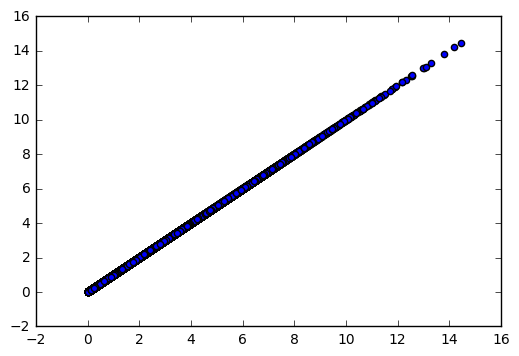

In [1445]:
plt.figure()
plt.scatter(jz0,jz)

In [916]:
def dist_j(J):
    return np.exp(-J)
scipy.integrate.quad(dist_j,0,6)[0]

0.9975212478233337

# COM motion with kicks

Analytical prefactor  = 0.577
Curve-fit prefact     = 0.615
Analytical equilibrium= 4.082
Curve-fit equilibrium = 4.122


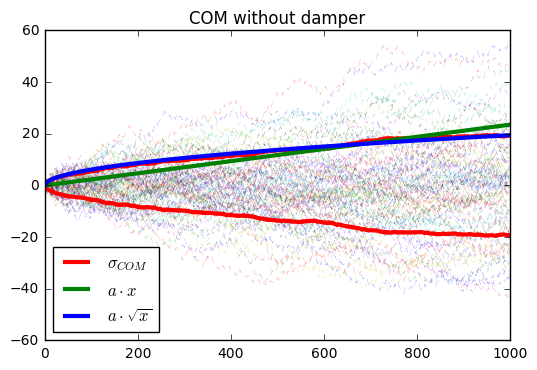

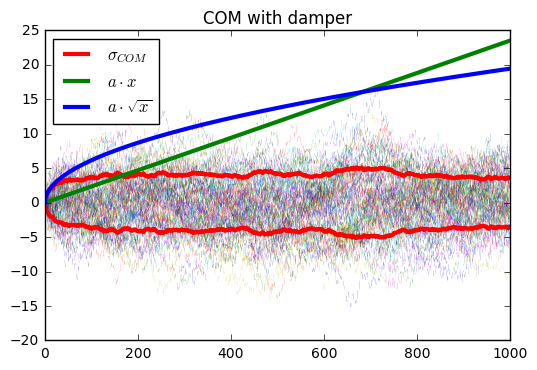

In [1058]:
nt = 1000
t = np.arange(nt)
n = 100
L=1
sig = L/np.sqrt(3)
kicks = np.random.uniform(-L,L,(n,nt))
# kicks = np.random.normal(0,sig,(n,nt))
com = np.cumsum(kicks,axis=1).transpose()
std_com = np.std(com,axis=1)

def f1(x,a):
    return x*a
def f2(x,a):
    return a*np.sqrt(x)
fit1,_ = scipy.optimize.curve_fit(f1,t, std_com)
fit2,_ = scipy.optimize.curve_fit(f2,t, std_com)


plt.figure()
plt.plot(com,'--',lw=0.1)
plt.plot(std_com,'r',lw=3,label=r'$\sigma_{COM}$')
plt.plot(-std_com,'r',lw=3)
plt.plot(t,f1(t,fit1),'g',lw=3,label=r'$a\cdot x$')
plt.plot(t,f2(t,fit2),'b',lw=3,label=r'$a\cdot \sqrt{x}$')
plt.title('COM without damper')
plt.legend(loc=0)
#######################
tau = 100
com2 = np.zeros_like(com)
for i,ti in enumerate(t):
    ts = (ti-t)[:i+1]
    fac =np.exp(-ts/tau)
#     if i<10:
#         print(fac)
#         print(ts)
    com2[i,:] = np.sum(kicks[:,:i+1]*fac,axis=1)
std_com2 = np.std(com2,axis=1)

# fit1,_ = scipy.optimize.curve_fit(f1,t, std_com2)
# fit2,_ = scipy.optimize.curve_fit(f2,t, std_com2)


plt.figure()
plt.plot(com2,'--',lw=0.1)
plt.plot(std_com2,'r',lw=3,label=r'$\sigma_{COM}$')
plt.plot(-std_com2,'r',lw=3)
plt.plot(t,f1(t,fit1),'g',lw=3,label=r'$a\cdot x$')
plt.plot(t,f2(t,fit2),'b',lw=3,label=r'$a\cdot \sqrt{x}$')
plt.title('COM with damper')
plt.legend(loc=0)
print('Analytical prefactor  = %.3f'%(L/np.sqrt(3)))
print('Curve-fit prefact     = %.3f'%fit2)
print('Analytical equilibrium= %.3f'%(L/np.sqrt(3)*np.sqrt(tau*0.5)))
print('Curve-fit equilibrium = %.3f'%np.mean(std_com2[int(nt*0.5):]))

# print(com.shape)
# print(com2.shape)
# print(com2)
# print(std_com)
# print(std_com2)
# print(fac)
# print(ts)

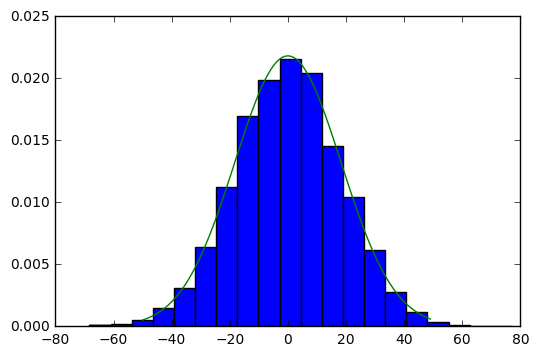

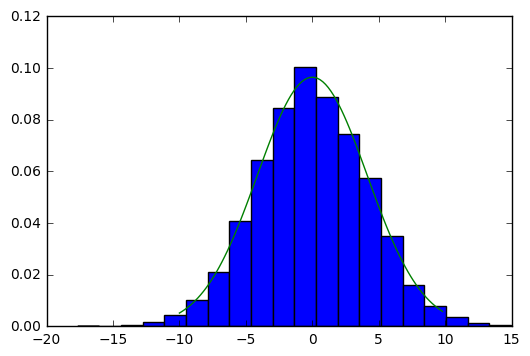

In [864]:
x = np.arange(-50,50)
plt.figure()
plt.hist(com[-1,:],bins=20,normed=True)
plt.plot(x,st.norm.pdf(x/std_com[-1])/std_com[-1])
x=x/5
plt.figure()
plt.hist(com2[-1,:],bins=20,normed=True)
plt.plot(x,st.norm.pdf(x/std_com2[-1])/std_com2[-1])


# Transition to 2D

Analytical prefactor    = 0.577
Curve-fit prefact       = 0.119
Analytical equilibrium r= 4.082
Analytical equilibrium x= 2.887
Curve-fit equilibrium   = 2.852


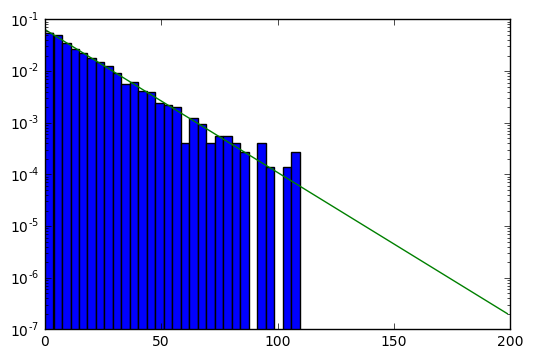

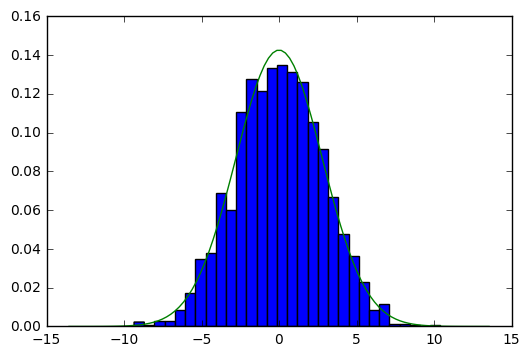

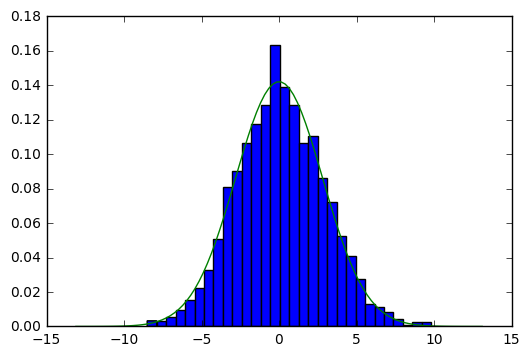

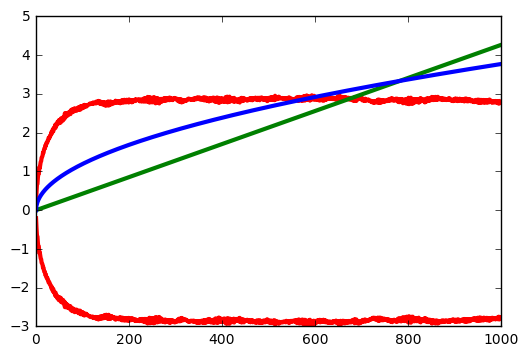

In [1060]:
g = 2/tau
mu = 2*np.pi*0.31
C = np.cos(mu)
S = np.sin(mu)
nt = 1000
t = np.arange(nt)
n = 2000
comx = np.zeros((nt,n))
comp = np.zeros((nt,n))
x = np.zeros(n)
p = np.zeros(n)

############################
######## tracking ##########
for i,ti in enumerate(t):
    p += np.random.uniform(-L,L,n)
    temp = x
    x = C*x + S*p
    p = -S*temp+C*p
    
    p -= g*p
    
    comx[i,:]=x
    comp[i,:]=p
    
    
std_comx = np.std(comx,axis=1)
std_comp = np.std(comp,axis=1)



# com=comp
# std_com = np.std(com,axis=1)
d = 1
com2d     = np.sqrt(comx**2+   d*   comp**2)    
std_com2d = np.sqrt(np.mean(com2d**2,axis=1))

com2d_sq     = comx**2 +   d*   comp**2
std_com2d_sq = (np.mean(com2d_sq,axis=1))/(1+d)

# print('test',np.all(std_com2d_sq==std_com2d_sq1))
# print(std_com2d_sq)
# print(std_com2d_sq1)

# maxx = np.max(np.abs(std_com))
# x = np.arange(0,maxx)
# plt.figure()
# plt.hist(com[-1,:],bins=20,normed=True)
# plt.plot(x,st.chi2.pdf(x,2))
# plt.plot(x,st.norm.pdf(x/std_com[-1])/std_com[-1])

if False:
    plt.figure()
    plt.hist2d(comx[-1,:],comp[-1,:])


coms = [comx,comp,        com2d    ,com2d_sq]
stds = [std_comx,std_comp,std_com2d,std_com2d_sq]
for i in [3,0,1]:
    comi = coms[i]
    std_comi = stds[i]
    maxx = np.max(np.abs(comi))
    plt.figure()
    
    plt.hist(comi[-1,:],bins=30,normed=True)
    
    if np.any(comi<0):
        x = np.linspace(-maxx,maxx,100)
        plt.plot(x,st.norm.pdf(x/std_comi[-1])/std_comi[-1])
    else:
        x = np.linspace(0,maxx,100)
#         plt.plot(x,st.chi2.pdf(x/std_comi[-1],2)/std_comi[-1])
        
        f = 1
        plt.plot(x,st.chi2.pdf( x/std_comi[-1]**f ,1+d)/std_comi[-1]**f)
#         plt.plot(x,st.chi2.pdf( x,1))
        plt.yscale('log')
    

i=1
comi = coms[i]
std_comi = stds[i]
    
    
fit1,_ = scipy.optimize.curve_fit(f1,t, std_comi)
fit2,_ = scipy.optimize.curve_fit(f2,t, std_comi)

plt.figure()
# plt.plot(comi,'--',lw=0.1)
plt.plot( std_comi,'r',lw=3)
plt.plot(-std_comi,'r',lw=3)
plt.plot(t,f1(t,fit1),'g',lw=3)
plt.plot(t,f2(t,fit2),'b',lw=3)


print('Analytical prefactor    = %.3f'%(L/np.sqrt(3)  ))
print('Curve-fit prefact       = %.3f'%fit2)
print('Analytical equilibrium r= %.3f'%(L/np.sqrt(3)*np.sqrt(tau*0.5)))
print('Analytical equilibrium x= %.3f'%(L/np.sqrt(3)*np.sqrt(tau*0.5*0.5)))
print('Curve-fit equilibrium   = %.3f'%np.mean(std_comi[int(nt*0.5):]))


# Other stuff

In [636]:
c[0,:]

array([ 0.,  1.,  2.])

In [685]:
st.norm.pdf(3)

0.0044318484119380075

NameError: name 'np' is not defined